###Go through the comments for explanation, if you couldn't understand then let me know

In [ ]:
#Installing the 3 boosting algorithms

!pip install xgboost --quiet
!pip install catboost --quiet
!pip install lightgbm --quiet

In [ ]:
import warnings # To suppress warnings
warnings.filterwarnings("ignore")

# Importing Dependencies

import numpy as np
import pandas as pd
import sys
import os

from datetime import datetime #To get the different attributes from a date, like Day, Month, Year 

import matplotlib as mpl
from matplotlib import pyplot

from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score # All the necessary visualization libs
from sklearn.metrics import accuracy_score,r2_score,f1_score,log_loss,recall_score    # and evaluation metrics
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance, plot_tree
from catboost import Pool,CatBoostClassifier,CatBoostRegressor

In [ ]:
input_path = r"/content/drive/My Drive/IBM/melbourne_temperature.csv"         # Path to the file contained in Drive
df = pd.read_table(input_path,sep = ',')                                      # Reading the dataframe from the csv file as a table

In [ ]:
# Checking Basic information available from dataset

df.info()  # 2 columns are there === Date and Temperature
print("\n\n\n\n")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB







,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
# The column "Date" is of type string, we are converting it to the type "datetime" to process easily
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d',errors = 'coerce') 

# The column "Temp" is of type string, we are converting to type "float" 
df.Temp = df['Temp'].astype('float64')

         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8


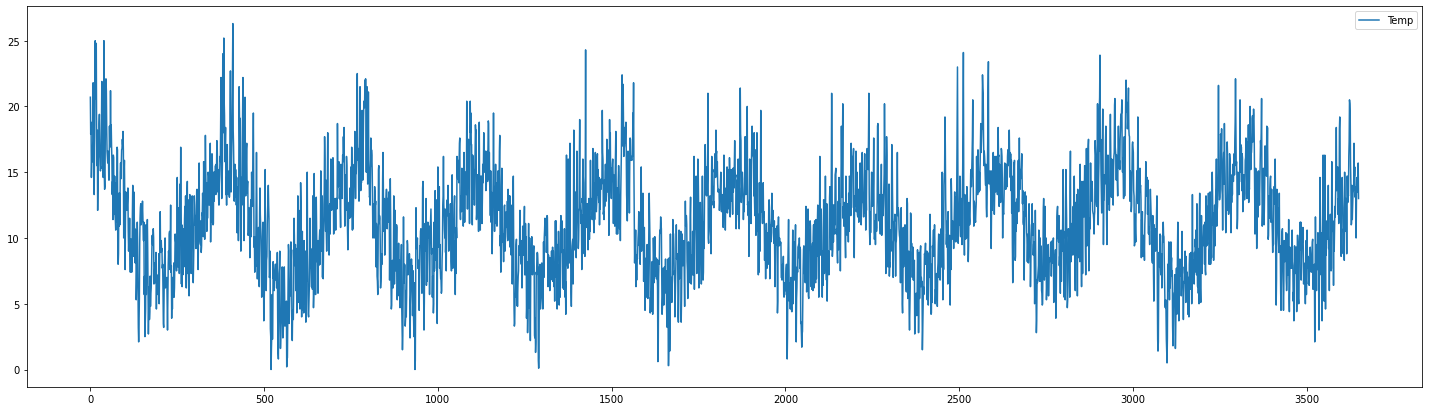

In [ ]:
# Here I am Roughly plotting Entire data to know the Seasonality/Trend

series = pd.read_table("/content/drive/My Drive/IBM/melbourne_temperature.csv",sep = ',')
print(series.head())
series.plot(figsize=(25,7))
pyplot.show()


## Data Shows a repeating pattern (or Seasonality) every 750 days (~ Approx 2 years once pattern repeats)

In [ ]:
split_date = round(df.Temp.count()*0.9)      # Total number of rows * 0.9 = 3650*0.9 
# print(split_date)                  

train = df.loc[:split_date].copy()    # Train set has 90% of the rows i.e 3286 days
test = df.loc[split_date:].copy()     # Validation set is 10% of the rows i.e. 365 days (1 year)

In [ ]:
# The below function will generate features (feature engineering) using the "Date" column

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.Date
    df['hour'] = df['date'].dt.hour  # Extracts the Hour from date if given
    df['dayofweek'] = df['date'].dt.dayofweek # Extracts day of the week 
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear # And so on....
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
train_x, train_y = create_features(train, label='Temp') ## Calling that function and assigning to the train and test sets ##
test_x, test_y = create_features(test, label='Temp')

In [ ]:
train_x.info() # See the number of columns , now we have more X features, so we can improve accuracy
print("\n\n\n")
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   hour        3286 non-null   int64
 1   dayofweek   3286 non-null   int64
 2   quarter     3286 non-null   int64
 3   month       3286 non-null   int64
 4   year        3286 non-null   int64
 5   dayofyear   3286 non-null   int64
 6   dayofmonth  3286 non-null   int64
 7   weekofyear  3286 non-null   int64
dtypes: int64(8)
memory usage: 205.5 KB




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 3285 to 3649
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   hour        365 non-null    int64
 1   dayofweek   365 non-null    int64
 2   quarter     365 non-null    int64
 3   month       365 non-null    int64
 4   year        365 non-null    int64
 5   dayofyear   365 non-null    int64
 6   dayofmonth  365 non-null    int64
 

## Below is code for applying the algorithms to the dataset, same as before

In [ ]:
### XGBoost ####

reg = xgb.XGBRegressor(n_estimators=1000)
t1=datetime.now()
reg.fit(train_x, train_y,
        eval_set=[(train_x, train_y), (test_x, test_y )],
        early_stopping_rounds=50,
       verbose=False)
t2=datetime.now()
execution_time_xgb = t2-t1
xgb_train_time = t2-t1
t3 = datetime.now()
y_pred = reg.predict(test_x)
t4 = datetime.now()
predictions = [round(value) for value in y_pred]
accuracy_xgb = round(r2_score(y_pred,test_y),5)
print("Accuracy score = ",accuracy_xgb*100,"%")
print("Execution time = ",execution_time_xgb)
print("Prediction time = ",t4-t3)

[13:29:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy score =  37.284 %
Execution time =  0:00:00.320775
Prediction time =  0:00:00.001530


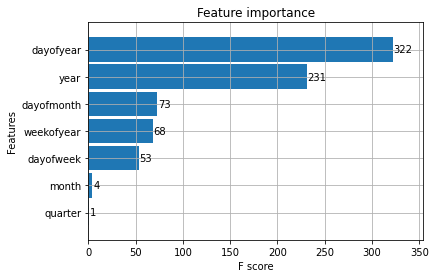

In [ ]:
_ = plot_importance(reg, height=0.9) 

# This will show a graph of the F1 score,
# which shows how much importance is given to each feature

In [ ]:
#### LightGBM #####

params = {
   'boosting_type': 'gbdt',
   'objective': 'regression',
   'random_state': 6,
   'feature_fraction': 0.09,
   'subsample':  0.25,
   'n_jobs': 4
}
num_round=20
train_x_lgb= train_x
train_y_lgb = train_y
t1=datetime.now()
lgbr = lgb.LGBMRegressor(**params)
model = lgbr.fit(train_x_lgb,y=train_y_lgb)
t2=datetime.now()
execution_time_lgbm = t2-t1
t3=datetime.now()
y_pred = model.predict(test_x)
t4=datetime.now()
accuracy_lgbm = round(r2_score(test_y,y_pred),5)
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

Accuracy score =  54.454 %
Execution time =  0:00:00.230593
Prediction time =  0:00:00.003897


In [ ]:
#### CatBoost ######

model = CatBoostRegressor(logging_level='Silent', random_state=45, 
                        early_stopping_rounds=300, )
cat_features = np.where(train_x.dtypes!=float)[0]
t1=datetime.now()
model.fit(train_x,train_y,cat_features = cat_features)
t2=datetime.now()
execution_time_cat_boost = t2-t1
t3 = datetime.now()
pred = model.predict(test_x)
t4 = datetime.now()
accuracy_cat_boost = round(r2_score(test_y,pred),5)
print("Accuracy score = ",accuracy_cat_boost*100,"%")
print("Execution time = ",execution_time_cat_boost)
print("Prediction time = ",t4-t3)
cat_boost_train_time = t2-t1

Accuracy score =  54.127 %
Execution time =  0:00:06.342166
Prediction time =  0:00:00.002960


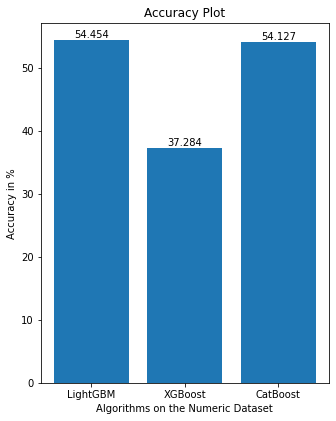

In [ ]:
##### Accuracy Plot #####

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (4,5))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

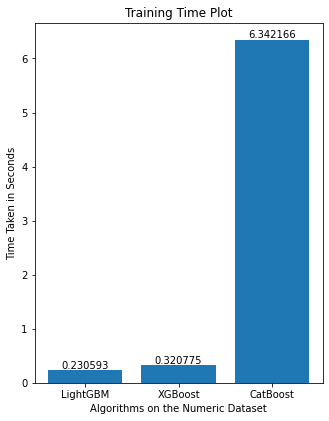

In [ ]:
##### Training Time Plot ####

lg = float(str(lgbm_train_time)[5:])
cb = float(str(cat_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (4,5))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
training_time = [lg,xgb,cb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()